# Ito Process Wavefront

In [39]:
# Modules
import jax.numpy as jnp
from jax import vmap

import os

from gp import diffusion


import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.patches as patches

In [40]:
#Hyper-parameters
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

x0 = jnp.zeros(2)
theta = jnp.pi/4

w0 = jnp.array([1.0, 0.0])
T = 1.0
N_sim = 10

seed = 2712
theta = jnp.pi/4
figure_path = 'Figures/ito_wavefront/'

## Defining the Wind and Radius as SDE's

In [41]:
def V_fun(t):
    
    return jnp.array([2.])

def W_mu(t, alpha=1.0):
    
    return jnp.array([-alpha*jnp.sin(alpha*t), alpha*jnp.cos(alpha*t)])

def W_sigma(t,alpha=1.0):
    
    return jnp.ones(2)

In [42]:
W_Ito = diffusion.DiffusionTime(W_mu, W_sigma, dim=2)

## Simulating the Wavefront 

In [43]:
tw, w_sim = W_Ito.sim(w0, t0=0, T=1.0, N_sim = N_sim)
tw_mu, w_mu = W_Ito.mu(w0,T)
tw_var, w_var = W_Ito.var(T)

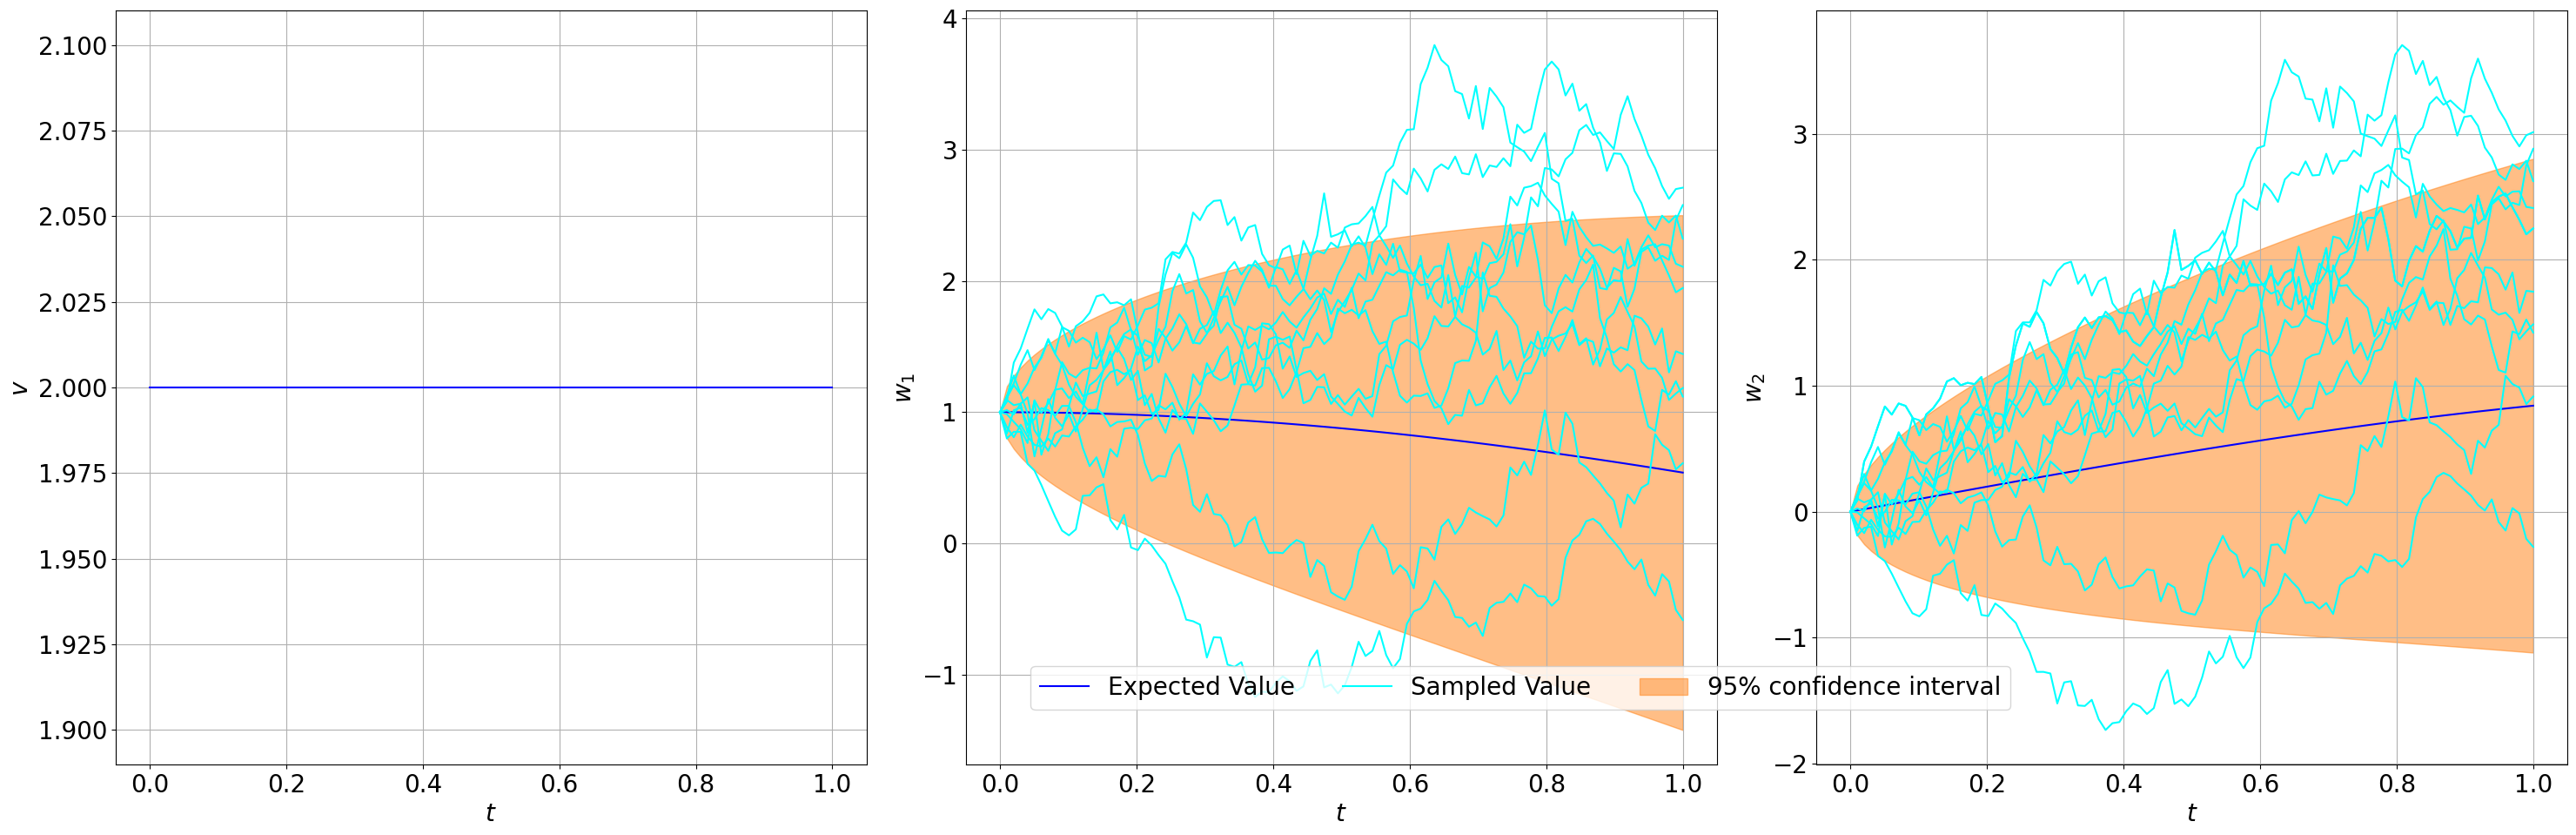

In [44]:
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(131)
ax.plot(jnp.linspace(0,T,100), vmap(V_fun)(jnp.linspace(0,T,100)), color='blue')
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$v$')
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(tw_mu, w_mu[:,0], color='blue')
ax.plot(tw, w_sim[:,:,0].T, color='cyan')
ax.fill_between(
    tw_var.ravel(),
    w_mu[:,0] - 1.96 * jnp.sqrt(w_var[:,0]),
    w_mu[:,0] + 1.96 * jnp.sqrt(w_var[:,0]),
    color="tab:orange",
    alpha=0.5,
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$w_{1}$')
ax.grid(True)

ax = fig.add_subplot(133)
ax.plot(tw_mu, w_mu[:,1], color='blue', label='Expected Value')
ax.plot(tw, w_sim[:,:,1].T, color='cyan')
ax.plot(tw, w_sim[0,:,1], color='cyan', label='Sampled Value')
ax.fill_between(
    tw_var.ravel(),
    w_mu[:,1] - 1.96 * jnp.sqrt(w_var[:,1]),
    w_mu[:,1] + 1.96 * jnp.sqrt(w_var[:,1]),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$w_{2}$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.15), ncol=5)

fig.tight_layout()
fig.savefig(os.path.join(figure_path, 'ito_prior_vw.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

## Maximum Likelihood Inference for $w_{1}$, $w_{2}$

In [45]:
theta_opt = W_Ito.max_likelihood(w_sim[:,1:], jnp.tile(tw[1:], (N_sim, 1)), w0, 1.0*jnp.ones(1))

Optimization terminated successfully.
         Current function value: 10.226015
         Iterations: 13
         Function evaluations: 28


In [46]:
theta_opt

array([1.2921872], dtype=float32)

In [47]:
theta_opt % (2*jnp.pi)

array([1.2921872], dtype=float32)

In [48]:
#tw, w_sim = W_Ito.sim(w0, 0., T, N_sim, theta_opt)
tw_mu, w_mu = W_Ito.mu(w0,T, theta_opt)
tw_var, w_var = W_Ito.var(T, theta_opt)

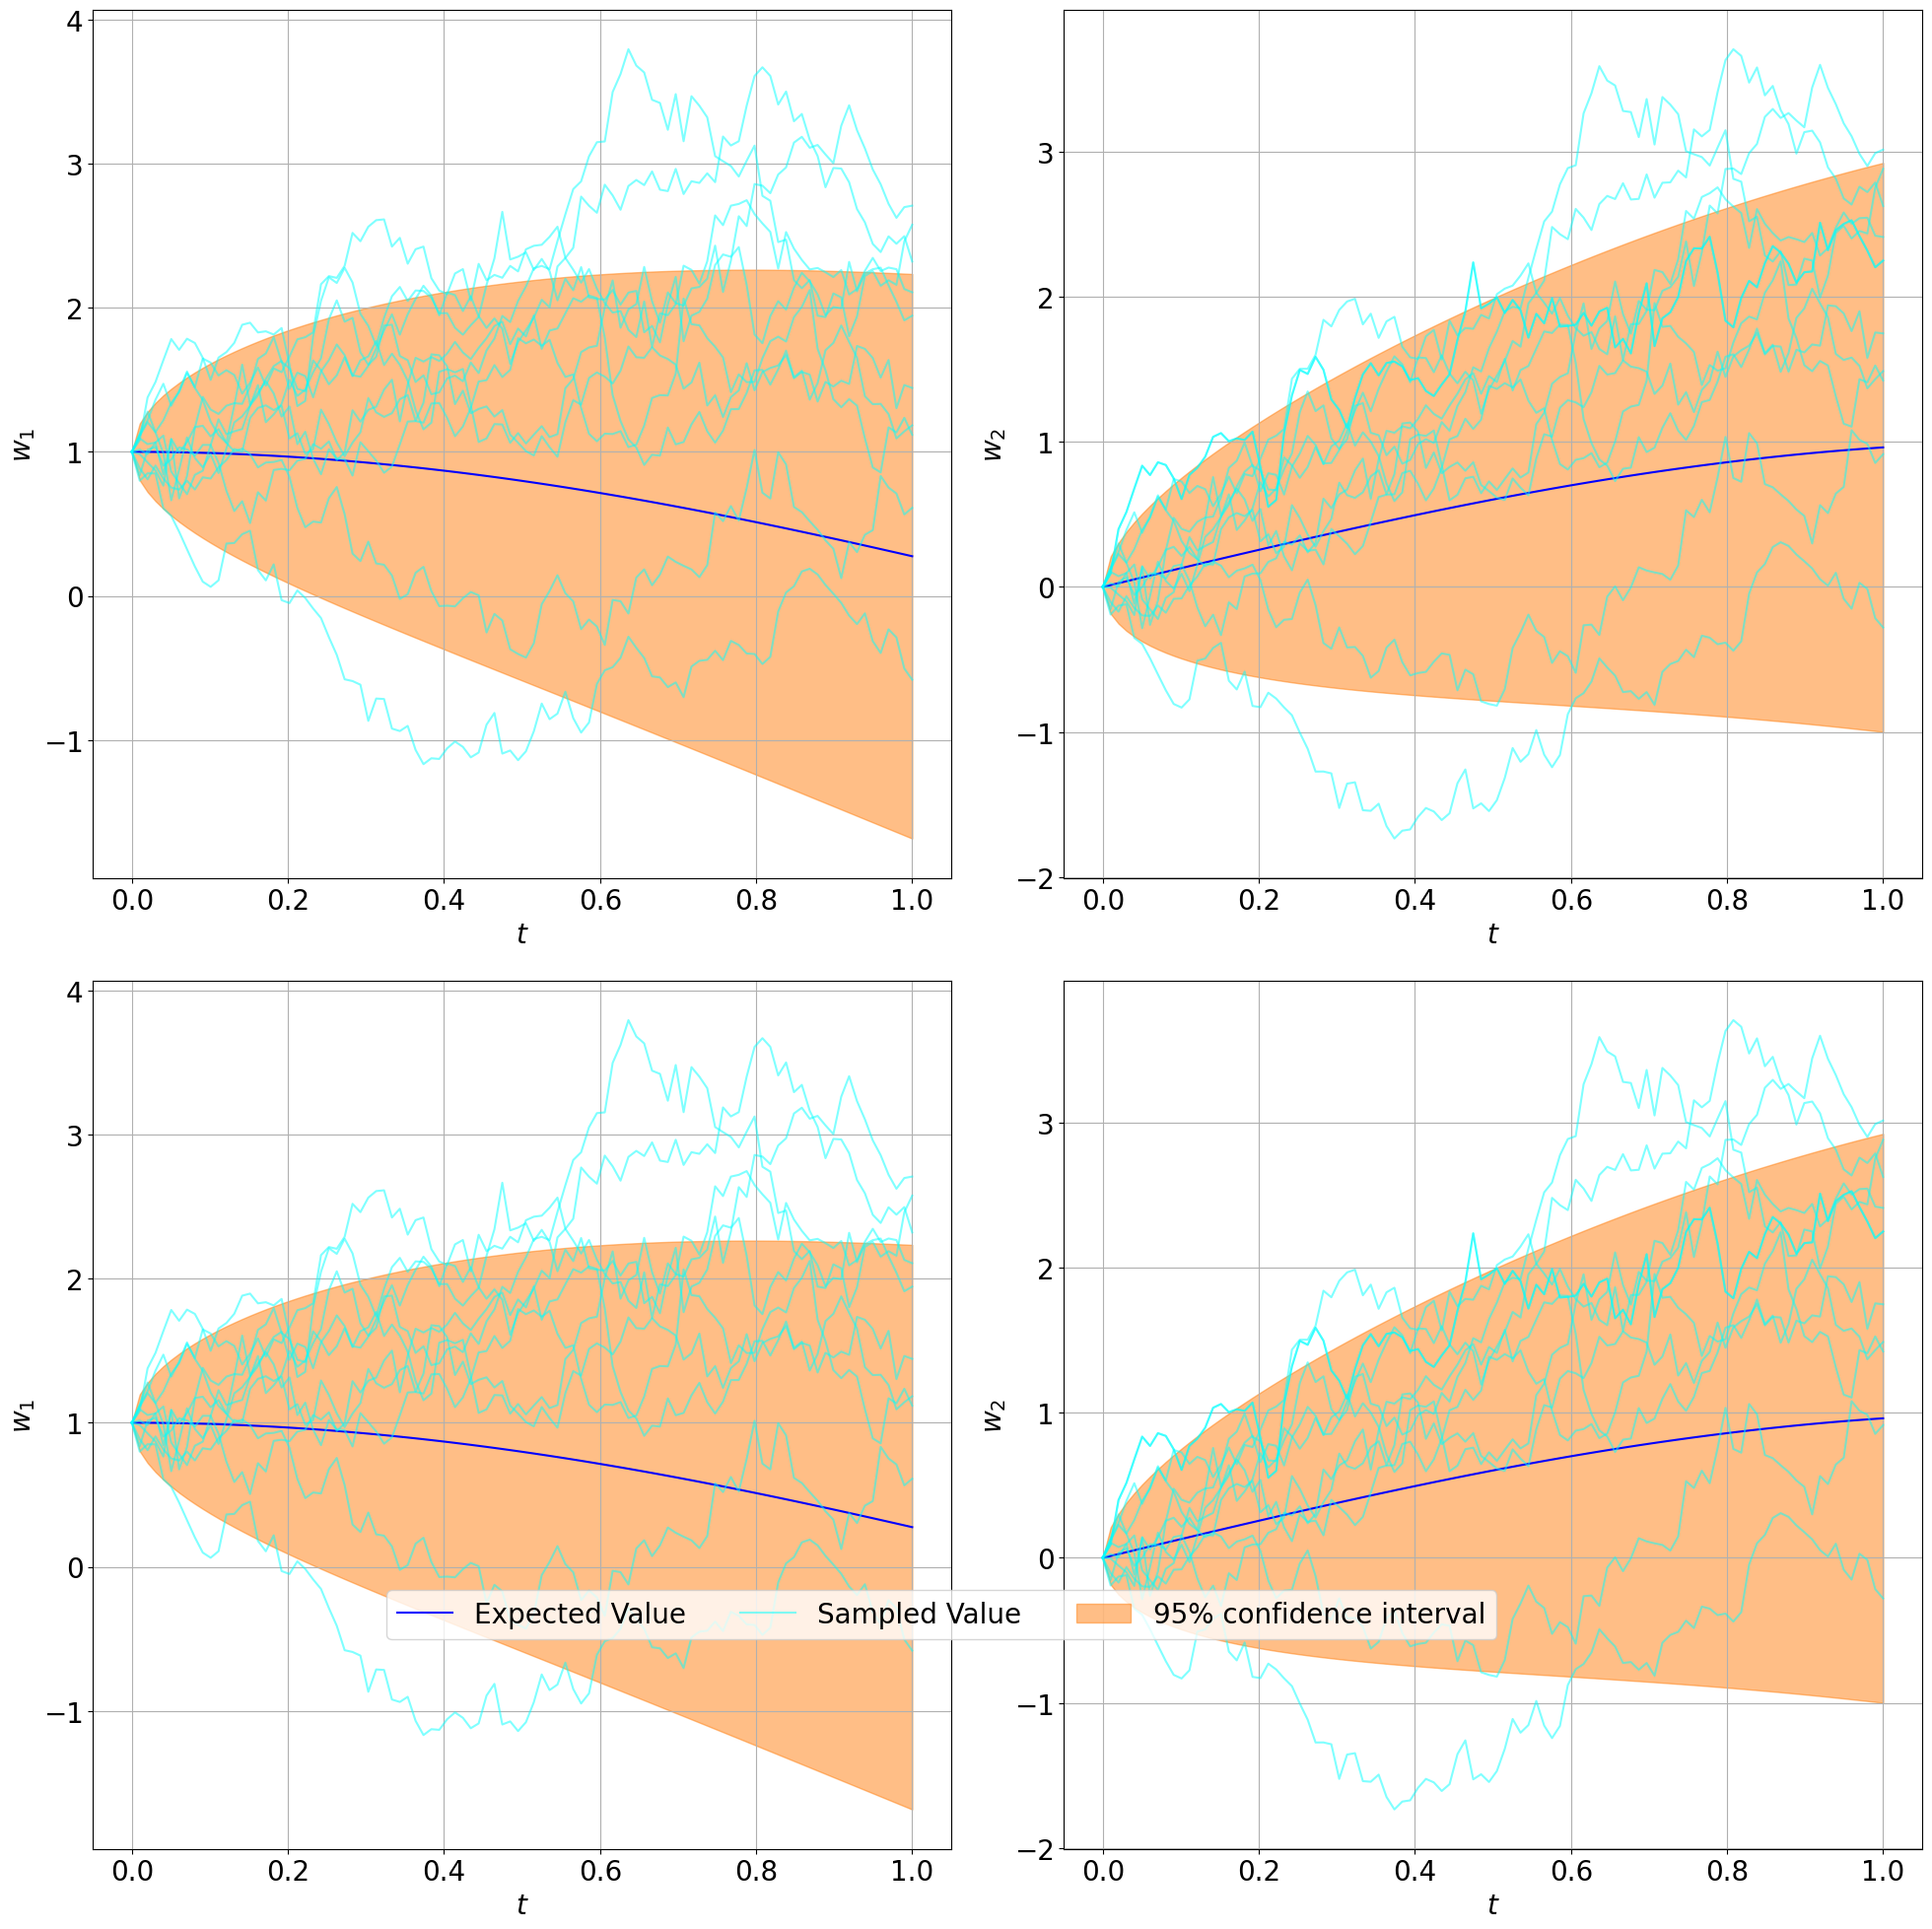

In [49]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(221)
ax.plot(tw_mu, w_mu[:,0], color='blue')
ax.plot(tw, w_sim[:,:,0].T, color='cyan', alpha=0.5)
ax.fill_between(
    tw_var.ravel(),
    w_mu[:,0] - 1.96 * jnp.sqrt(w_var[:,0]),
    w_mu[:,0] + 1.96 * jnp.sqrt(w_var[:,0]),
    color="tab:orange",
    alpha=0.5,
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$w_{1}$')
ax.grid(True)

ax = fig.add_subplot(222)
ax.plot(tw_mu, w_mu[:,1], color='blue')
ax.plot(tw, w_sim[:,:,1].T, color='cyan', alpha=0.5)
ax.plot(tw, w_sim[0,:,1], color='cyan', alpha=0.5)
ax.fill_between(
    tw_var.ravel(),
    w_mu[:,1] - 1.96 * jnp.sqrt(w_var[:,1]),
    w_mu[:,1] + 1.96 * jnp.sqrt(w_var[:,1]),
    color="tab:orange",
    alpha=0.5,
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$w_{2}$')
ax.grid(True)

ax = fig.add_subplot(223)
ax.plot(tw_mu, w_mu[:,0], color='blue')
ax.plot(tw, w_sim[:,:,0].T, color='cyan', alpha=0.5)
ax.fill_between(
    tw_var.ravel(),
    w_mu[:,0] - 1.96 * jnp.sqrt(w_var[:,0]),
    w_mu[:,0] + 1.96 * jnp.sqrt(w_var[:,0]),
    color="tab:orange",
    alpha=0.5,
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$w_{1}$')
ax.grid(True)

ax = fig.add_subplot(224)
ax.plot(tw_mu, w_mu[:,1], color='blue', label='Expected Value')
ax.plot(tw, w_sim[:,:,1].T, color='cyan', alpha=0.5)
ax.plot(tw, w_sim[0,:,1], color='cyan', label='Sampled Value', alpha=0.5)
ax.fill_between(
    tw_var.ravel(),
    w_mu[:,1] - 1.96 * jnp.sqrt(w_var[:,1]),
    w_mu[:,1] + 1.96 * jnp.sqrt(w_var[:,1]),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$w_{2}$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.20,0.15), ncol=5)

fig.tight_layout()
fig.savefig(os.path.join(figure_path, 'ito_simple_vw.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

## Sampling the Wavefront

In [50]:
def trapez_rule(f, t):
    
    dt = jnp.diff(t)
    #fval = vmap(f)(t)
    fval = f
    
    return jnp.concatenate((jnp.zeros(1), jnp.cumsum(0.5*dt*(fval[1:]+fval[:-1]))))

In [51]:
def x0_fun(t_grid,*phi):
    
    v = trapez_rule(v_mu, t_grid)[-1]
    
    return x0+jnp.array([jnp.cos(theta), jnp.sin(theta)])*v

In [52]:
v_mu = vmap(V_fun)(tw).squeeze()
x1_sim = vmap(lambda w1: x0[0]+jnp.cos(theta)*trapez_rule(v_mu, tw)+trapez_rule(w1,tw))(w_sim[:,:,0])
x2_sim = vmap(lambda w2: x0[1]+jnp.sin(theta)*trapez_rule(v_mu, tw)+trapez_rule(w2,tw))(w_sim[:,:,1])

x1_mu = x0[0]+jnp.cos(theta)*trapez_rule(v_mu, tw)+trapez_rule(w_mu[:,0],tw_mu)
x2_mu = x0[1]+jnp.sin(theta)*trapez_rule(v_mu, tw)+trapez_rule(w_mu[:,1],tw_mu)

In [53]:
x_data = jnp.transpose(jnp.array([x1_sim, x2_sim]), axes=(1,2,0))
theta_opt = W_Ito.integral_max_likelihood(x_data[:,1:], jnp.tile(tw[1:], (N_sim, 1)), x0_fun, 2, .2*jnp.ones(1))

Optimization terminated successfully.
         Current function value: 9.356260
         Iterations: 20
         Function evaluations: 43


In [59]:
theta_opt

array([1.351873], dtype=float32)

In [54]:
x_mean = vmap(lambda t: W_Ito.integral_mu(w0,x0_fun, t, 1.0))(tw)
x_var = vmap(lambda t: W_Ito.integral_var(t, 1.0))(tw)

In [55]:
x_post_mean = vmap(lambda t: W_Ito.integral_mu(w0,x0_fun, t, theta_opt))(tw)
x_post_var = vmap(lambda t: W_Ito.integral_var(t, theta_opt))(tw)

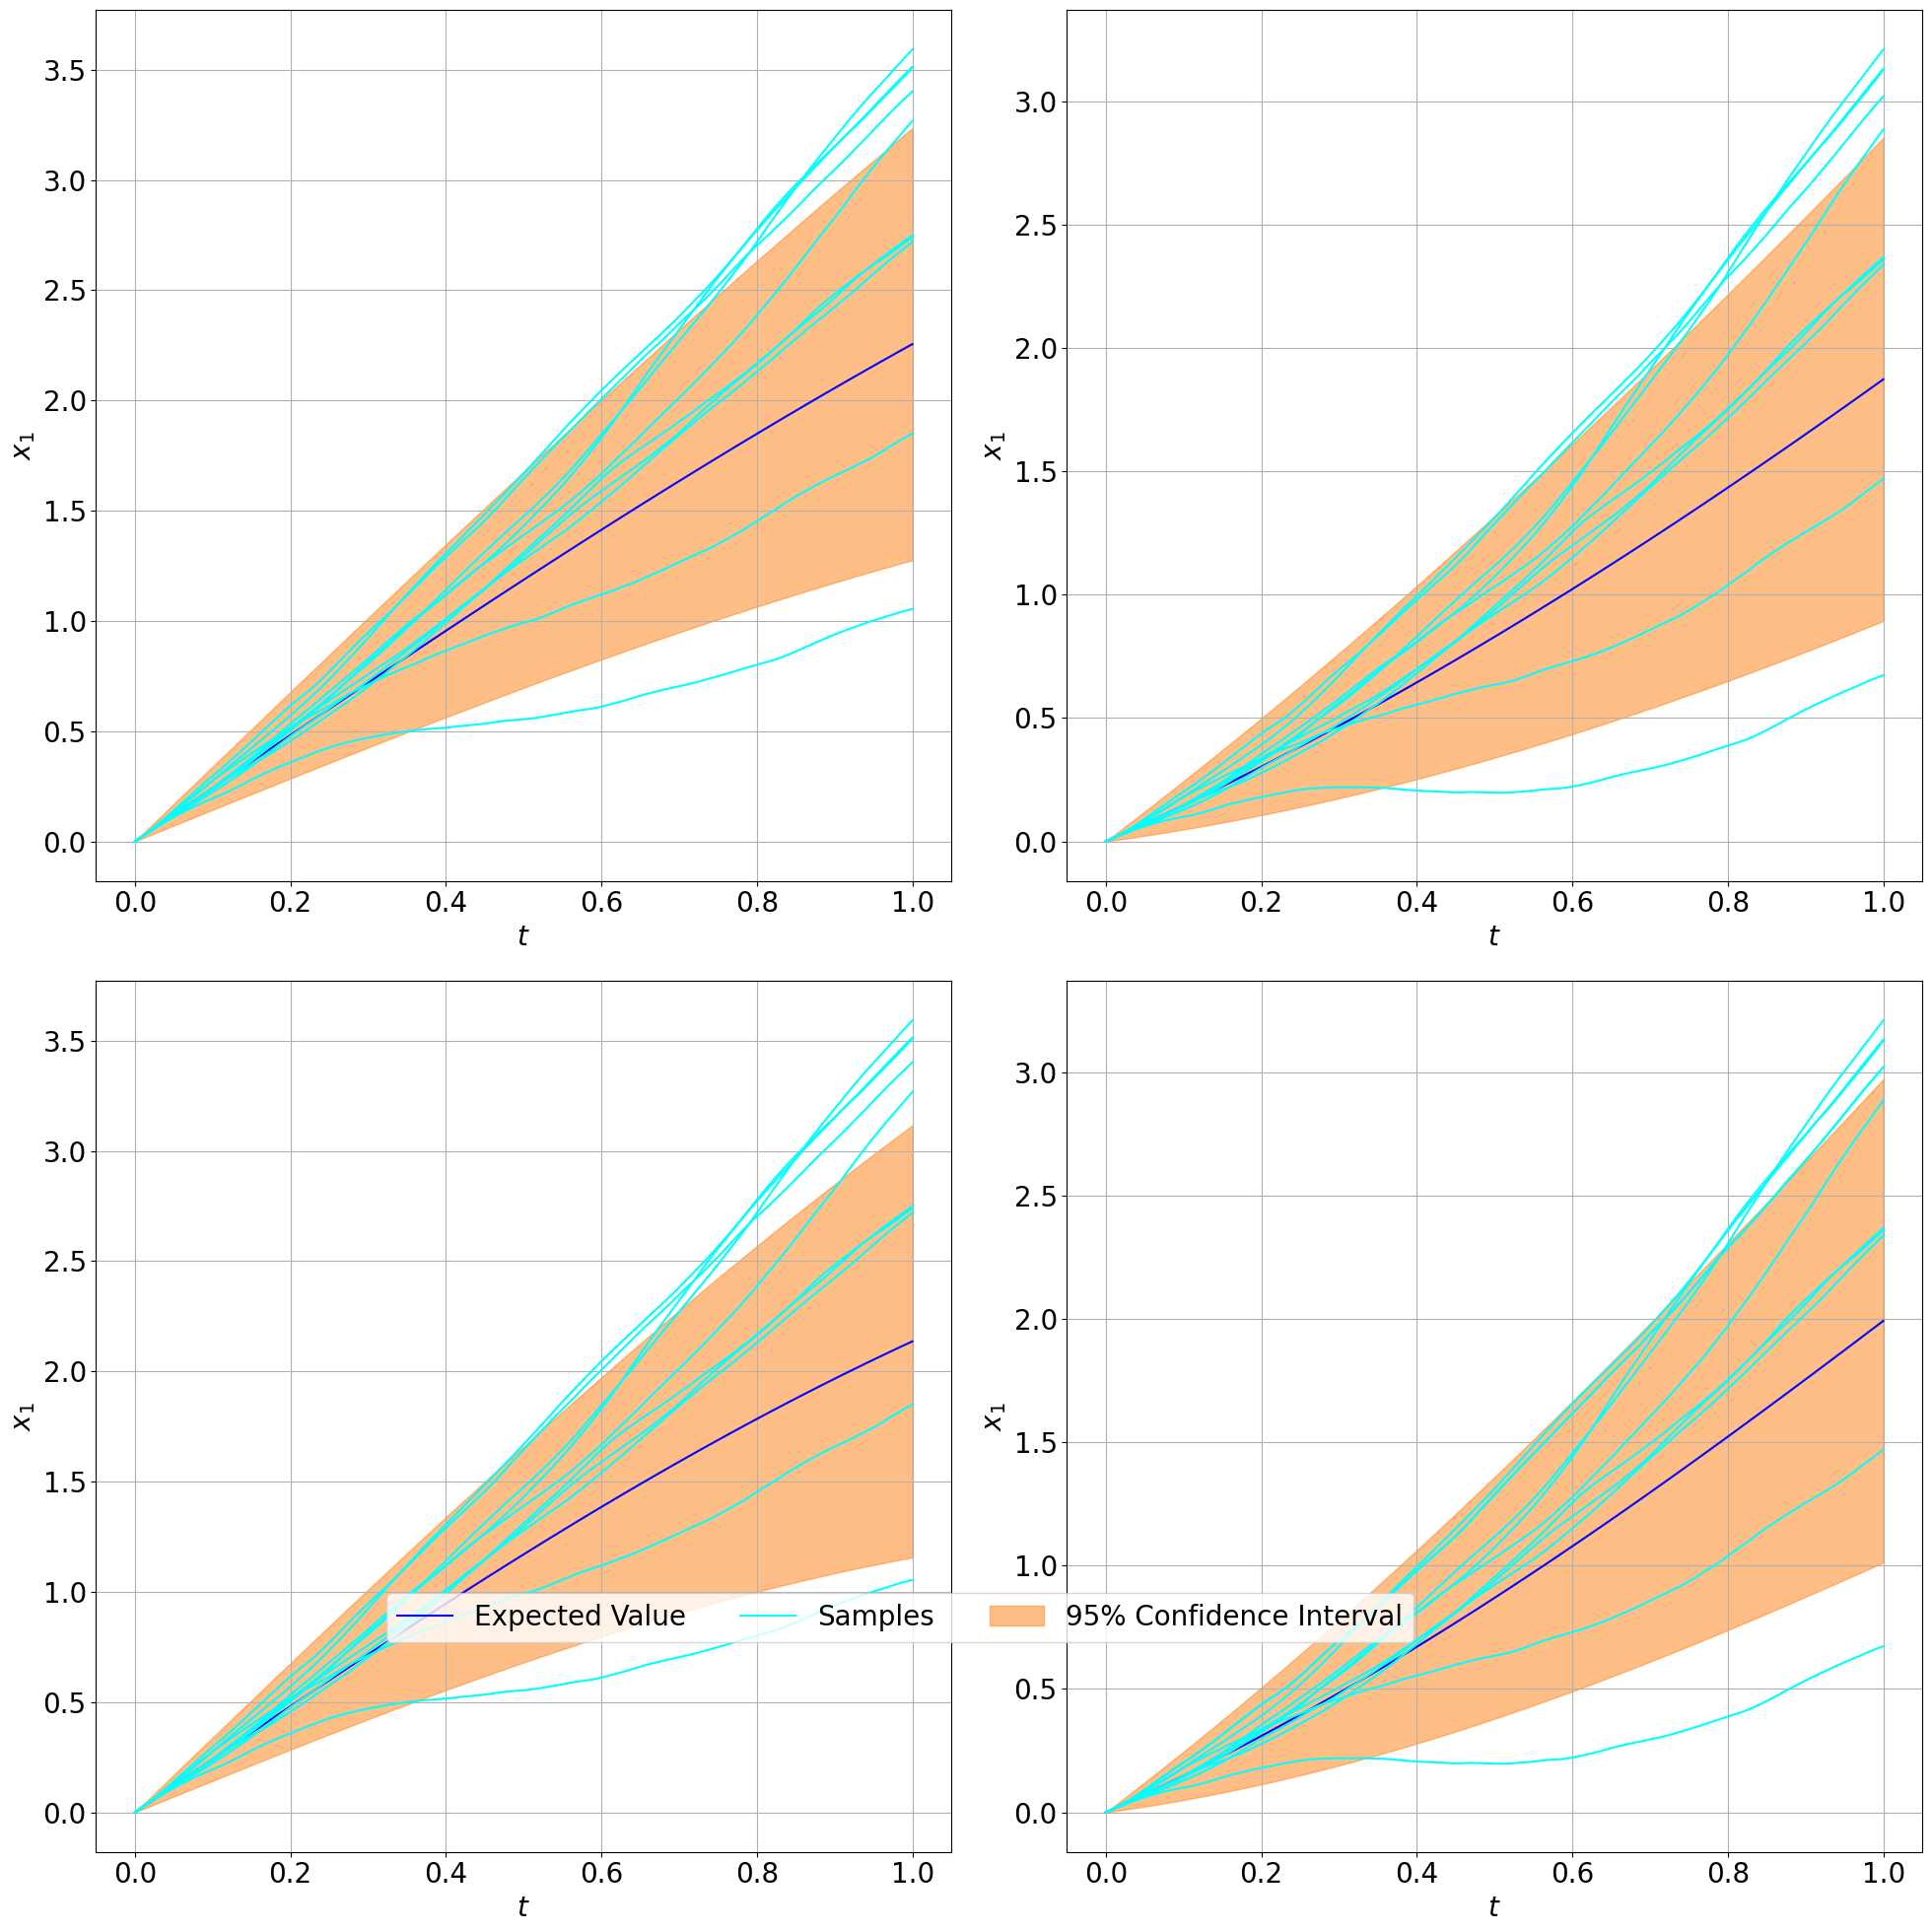

In [56]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(221)
ax.plot(tw, x_mean[:,0], color='blue')
ax.plot(tw, x1_sim.T, color='cyan')
ax.fill_between(
    tw.ravel(),
    x_mean[:,0] - 1.96 * jnp.sqrt(x_var[:,0]),
    x_mean[:,0] + 1.96 * jnp.sqrt(x_var[:,0]),
    color="tab:orange",
    alpha=0.5,
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$x_{1}$')
ax.grid(True)

ax = fig.add_subplot(222)
ax.plot(tw, x_mean[:,1], color='blue')
ax.plot(tw, x2_sim.T, color='cyan')
ax.fill_between(
    tw.ravel(),
    x_mean[:,1] - 1.96 * jnp.sqrt(x_var[:,1]),
    x_mean[:,1] + 1.96 * jnp.sqrt(x_var[:,1]),
    color="tab:orange",
    alpha=0.5,
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$x_{1}$')
ax.grid(True)

ax = fig.add_subplot(223)
ax.plot(tw, x_post_mean[:,0], color='blue')
ax.plot(tw, x1_sim.T, color='cyan')
ax.fill_between(
    tw.ravel(),
    x_post_mean[:,0] - 1.96 * jnp.sqrt(x_post_var[:,0]),
    x_post_mean[:,0] + 1.96 * jnp.sqrt(x_post_var[:,0]),
    color="tab:orange",
    alpha=0.5,
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$x_{1}$')
ax.grid(True)

ax = fig.add_subplot(224)
ax.plot(tw, x_post_mean[:,1], color='blue', label='Expected Value')
ax.plot(tw, x2_sim.T, color='cyan')
ax.plot(tw, x2_sim[0], color='cyan', label='Samples')
ax.fill_between(
    tw.ravel(),
    x_post_mean[:,1] - 1.96 * jnp.sqrt(x_post_var[:,1]),
    x_post_mean[:,1] + 1.96 * jnp.sqrt(x_post_var[:,1]),
    color="tab:orange",
    alpha=0.5,
    label='95% Confidence Interval'
)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$x_{1}$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.20,0.15), ncol=5)

fig.tight_layout()
fig.savefig(os.path.join(figure_path, 'ito_simple_x1x2.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

In [57]:
import scipy.stats
i = 50
probx1 = []
probx2 = []
for i in range(len(x_mean)):
    probx1.append(scipy.stats.norm(x_mean[i,0], x_var[i,0]).cdf(2.0)-scipy.stats.norm(x_mean[i,0], x_var[i,0]).cdf(1.5))
    probx2.append(scipy.stats.norm(x_mean[i,1], x_var[i,1]).cdf(1.5)-scipy.stats.norm(x_mean[i,1], x_var[i,1]).cdf(1.0))
    
probx1 = jnp.stack(probx1)
probx2 = jnp.stack(probx2)
prob = probx1*probx2

/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


/tmp/ipykernel_29470/746088848.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((1.5, 1.0), 0.5, 0.5, linewidth=1, edgecolor='r', color='red', alpha=0.2)


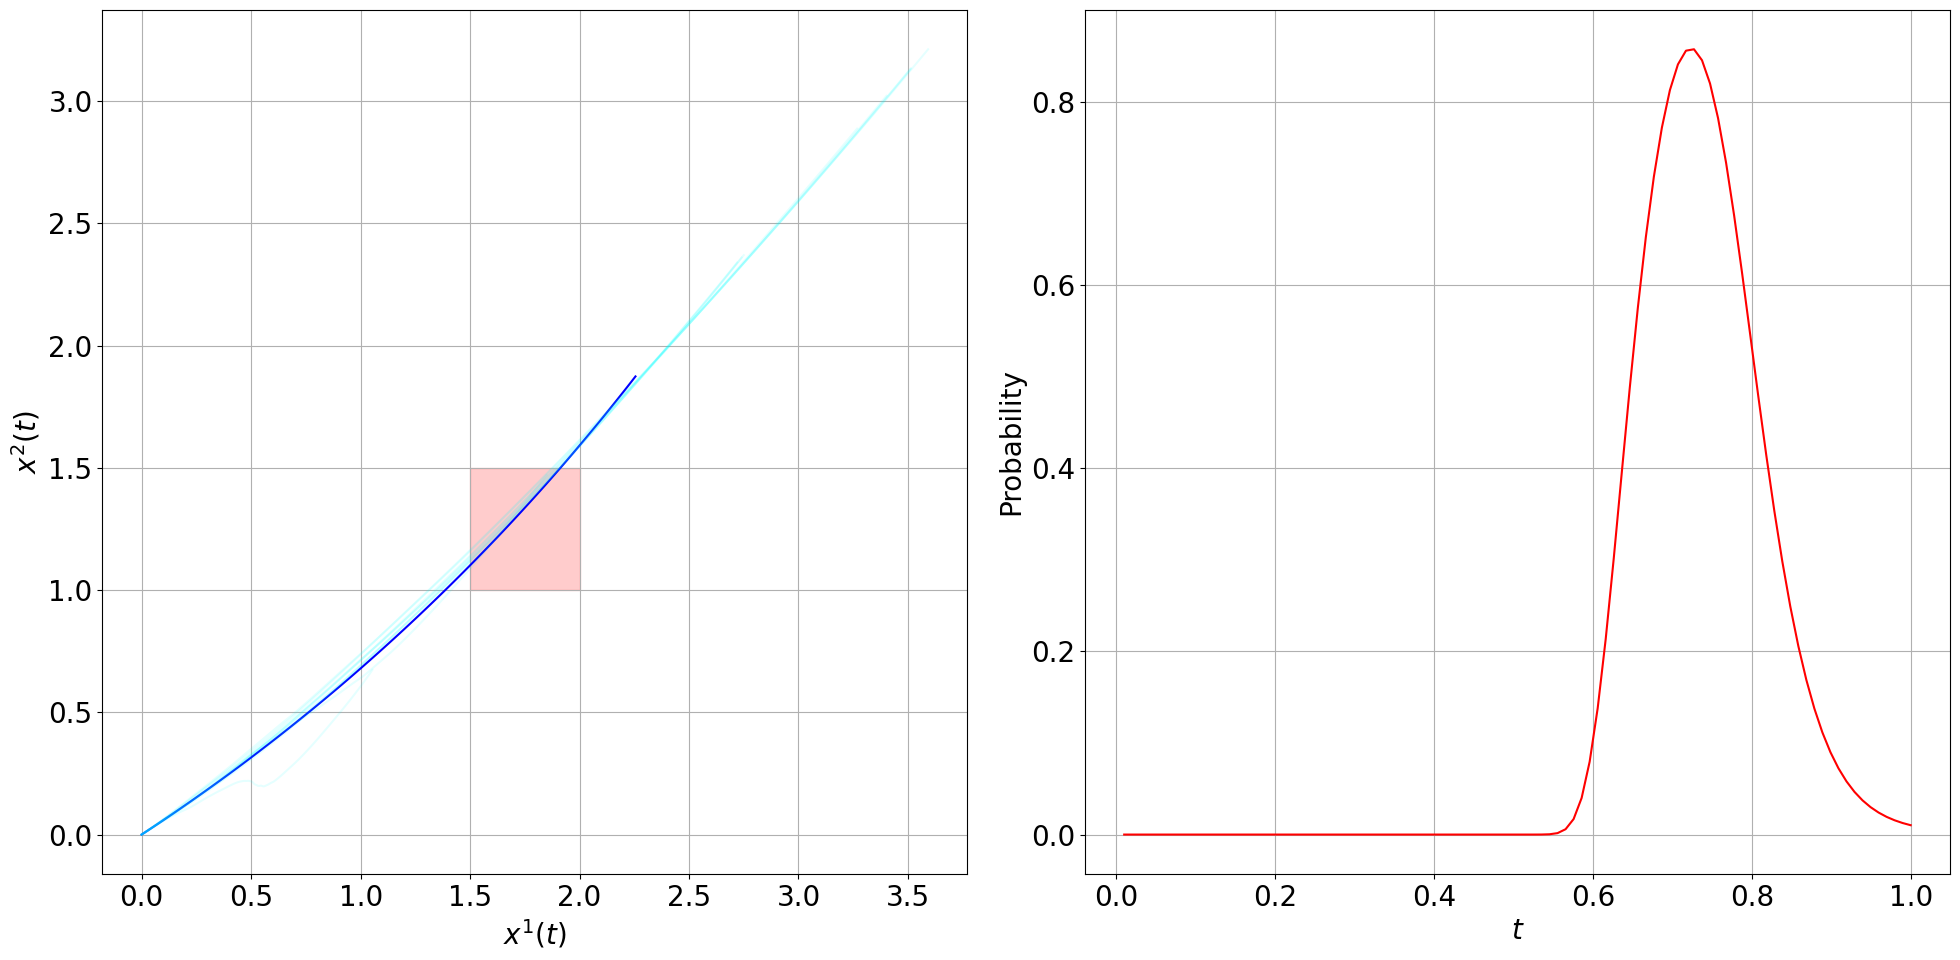

In [58]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121)
ax.plot(x_mean[:,0], x_mean[:,1], color='blue')
ax.plot(x1_sim.T, x2_sim.T, color='cyan', alpha=0.1)
ax.grid(True)
ax.set_xlabel(r'$x^{1}(t)$')
ax.set_ylabel(r'$x^{2}(t)$')

# Create a Rectangle patch
rect = patches.Rectangle((1.5, 1.0), 0.5, 0.5, linewidth=1, edgecolor='r', color='red', alpha=0.2)

# Add the patch to the Axes
ax.add_patch(rect)

ax = fig.add_subplot(122)
ax.plot(jnp.linspace(0,1,100), prob, color='red')
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Probability')

fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'ito_simple_prob.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')